In [1]:
import numpy as np
import stochasticTN as stn
import matplotlib.pyplot as plt
import networkx as nx
from scipy.sparse.linalg import eigs, eigsh

# Network $\epsilon$-SIS model

Examples of steady state network $\epsilon$-SIS computations using MPS and DMRG. First let's run the basic algorithm for a small randomly generated network using the Barabasi-Albert algorithm.

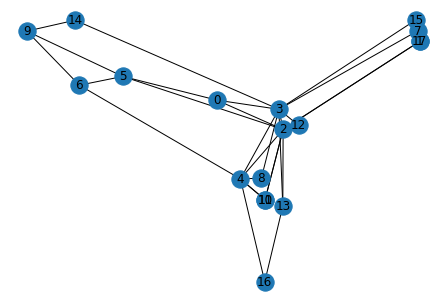

In [15]:
# Create a network using `NetworkX`
n =18 # number of nodes 
G = nx.barabasi_albert_graph(n,2)
pos = nx.spectral_layout(G)
nx.draw(G, pos= pos, with_labels = True)

In [16]:
# Find good ordering of nodes according to Fiedler vector
perm = stn.find_permutation(nx.laplacian_matrix(G).astype('float'))
A = nx.adjacency_matrix(G).toarray()
Aordered = A[perm][:,perm]

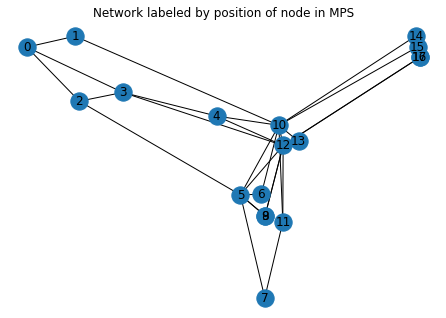

In [17]:
nx.draw(G, pos = pos, labels = {perm[i]: i for i in range(n)})
plt.title("Network labeled by position of node in MPS")
plt.show()

## DMRG method for steady state

In [18]:
# Set parameters:
lam = 0.6
epsilon = 1e-2

# Define MPO
mpo = stn.network_SIS(Aordered,lam, 0, epsilon)
print("MPO bond dimensions : ", mpo.bond_dimensions)

#Initialize random MPS
mps = stn.randomMPS(n, 40)

#initialize the dmrg routine
dmrg = stn.DMRG(mps, mpo)

#run DMRG 
dens, var, err, converged = dmrg.run_double_site_dmrg(MaxSweeps=50, cutoff=1e-8, Dmax=250, verbose=True)


MPO bond dimensions :  [1, 4, 7, 9, 9, 9, 9, 9, 11, 11, 9, 9, 7, 7, 7, 6, 4, 4, 1]
VarMPS sites=(0,1)/18: optimized E=-5.078012060559895e-09, D = 2,  truncated SVs = 0   193276881990075e-08     
r = 0.600000,   n_s =  3,   dens = 0.417543715,   var = 0.045138952   tps = 9.51s   <D>= 48.41   maxD = 154


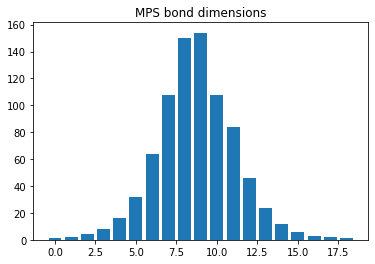

In [19]:
plt.bar([i for i in range(n+1)],mps.bond_dimensions)
plt.title("MPS bond dimensions")
plt.show()

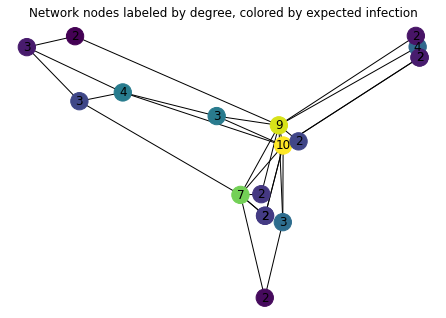

In [20]:
expectationValues = np.array([stn.single_site_occupancy(mps, i) for i in range(n)])
invPerm = np.argsort(perm)

nx.draw(G, pos, node_color = expectationValues[invPerm], labels = {i: G.degree[i] for i in range(n)})
plt.title("Network nodes labeled by degree, colored by expected infection")
plt.show()

### Compute observables for a range of $\lambda$ values

In [22]:
rlist = np.linspace(0.05,2,40)
mps = stn.randomMPS(n,24)
results = np.zeros((len(rlist),6))
for ir, r in enumerate(rlist):
    mpo = stn.network_SIS(Aordered,r,0,epsilon=0.01)
    dmrg = stn.DMRG(mps,mpo)
    density, var, err, converged = dmrg.run_double_site_dmrg(MaxSweeps = 20, cutoff=1e-8, verbose=True)
    results[ir] = [r, density, var, err, stn.singular_value_entropy(mps, n//2-1), converged]

VarMPS sites=(0,1)/18: optimized E=-1.367708424182448e-07, D = 2,  truncated SVs = 0   4762309462911904e-08    
r = 0.050000,   n_s =  5,   dens = 0.012037436,   var = 0.000805635   tps = 0.52s   <D>= 10.29   maxD = 19
VarMPS sites=(0,1)/18: optimized E=-1.0136547515372967e-06, D = 2,  truncated SVs = 0  3108576810909817e-09    
r = 0.100000,   n_s =  6,   dens = 0.015310934,   var = 0.001294786   tps = 0.64s   <D>= 14.65   maxD = 30
VarMPS sites=(0,1)/18: optimized E=-1.2811587199297993e-06, D = 2,  truncated SVs = 0  0364321703651e-09       
r = 0.150000,   n_s =  8,   dens = 0.020451586,   var = 0.002222208   tps = 0.99s   <D>= 18.82   maxD = 41
VarMPS sites=(0,1)/18: optimized E=-2.310773680800607e-06, D = 2,  truncated SVs = 0    53800418258133e-08     
r = 0.200000,   n_s =  6,   dens = 0.028706280,   var = 0.003972091   tps = 1.23s   <D>= 22.47   maxD = 52
VarMPS sites=(0,1)/18: optimized E=-2.849664060585993e-06, D = 2,  truncated SVs = 0   590053801172556e-08     
r = 0.250000

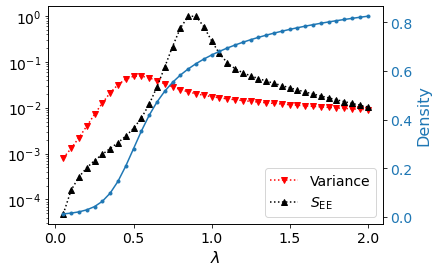

In [24]:
plt.rc('xtick', labelsize=14) 
plt.rc('ytick', labelsize=14) 

fig, ax1 = plt.subplots()


ax2 = ax1.twinx() 
ax2.tick_params(axis ='y', labelcolor = 'tab:blue')

ax1.plot(rlist, results[:,2], 'v:', color='red', label = r'Variance')
ax1.plot(rlist, results[:,4], '^:', color='black', label = r'$S_{\rm EE}$')
ax2.plot(rlist, results[:,1], '.-')
ax2.set_ylabel('Density',size=16, color='tab:blue')

ax1.set_xlabel(r'$\lambda$',size=16)
ax1.set_yscale('log')
ax1.legend(loc = 4, prop= {'size':14})

plt.show()